In [1]:
import pandas as pd, numpy as np
import os
import math
from math import ceil, floor, log
import random

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

from yellowbrick.classifier import ClassificationReport
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import catboost
print(catboost.__version__)
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier
import pandas

0.24.2
/home/haojie/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/tmp.csv')

In [3]:
import seaborn as sns
from collections import Counter

In [4]:
# 缺失值检测处理：轮盘法按概率填充（标称属性）
import random

null_pro = ['Driving_License', 'Policy_Sales_Channel']
for pro in null_pro:
    countPro = Counter([x for x in df_train[pro] if pd.isnull(x) == False])
    sumPro = sum(countPro.values())
    for index in range(len(df_train[pro])):
        if pd.isnull(df_train[pro][index]):
            needle = random.random() 
            needle *= sumPro
            for cur in countPro.most_common():
                needle -= cur[1]
                if needle <= 0:
                    df_train[pro][index] = cur[0]
                    break
df_train.info()

/home/haojie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304888 entries, 0 to 304887
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    304888 non-null  int64  
 1   Gender                304888 non-null  object 
 2   Age                   304888 non-null  int64  
 3   Driving_License       304888 non-null  float64
 4   Region_Code           304888 non-null  float64
 5   Previously_Insured    304888 non-null  int64  
 6   Vehicle_Age           304888 non-null  object 
 7   Vehicle_Damage        304888 non-null  object 
 8   Annual_Premium 

In [5]:
col_list = df_train.columns.to_list()[1:]
df_train_corr = df_train.copy().set_index('id')
df_train_ones = df_train_corr.loc[df_train_corr.Response == 1].copy()

categorical_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']
text_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# code text categorical features
le = preprocessing.LabelEncoder()
for f in text_features :
    df_train_corr[f] = le.fit_transform(df_train_corr[f])
# change digital categorical datatype so CatBoost can deal with them
df_train_corr.Region_Code = df_train_corr.Region_Code.astype('int32')
df_train_corr.Policy_Sales_Channel = df_train_corr.Policy_Sales_Channel.astype('int32')

In [6]:
df_train_corr.dtypes

Gender                    int64
Age                       int64
Driving_License         float64
Region_Code               int32
Previously_Insured        int64
Vehicle_Age               int64
Vehicle_Damage            int64
Annual_Premium          float64
Policy_Sales_Channel      int32
Vintage                   int64
Response                  int64
dtype: object

In [7]:
bins = [10,20, 30, 40, 50, 60, 70, 80, 90, 100]
df_train_corr['bin_age'] = pd.cut(df_train_corr['Age'], bins) 
df_train_corr['age_bin_cat'] = le.fit_transform(df_train_corr['bin_age']) 
df_train_corr['age_bin_cat'].value_counts()

1    124064
3     60915
2     44025
4     36327
5     22238
6     12220
0      4991
7       108
Name: age_bin_cat, dtype: int64

In [8]:
SEED = 306

In [9]:
def upsample(df, u_feature, n_upsampling):
    ones = df.copy()
    for n in range(n_upsampling):
        if u_feature == 'Annual_Premium':
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-1,1)* x *0.05) # change Annual_premiun in the range of 5%
        else:
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-5,5)) # change Age in the range of 5 years
                
        if n == 0:
            df_new = df.copy()
        else:
            df_new = pd.concat([df_new, df])
    return df_new

try:
    df_train_corr.drop(columns = ['bin_age'], inplace = True)
except:
    print('already deleted')        
df_train_mod = df_train_corr.copy()
df_train_mod['old_damaged'] = df_train_mod.apply(lambda x: pow(2,x.Vehicle_Age)+pow(2,x.Vehicle_Damage), axis =1)

# we shall preserve validation set without augmentation/over-sampling
df_temp, X_valid, _, y_valid = train_test_split(df_train_mod, df_train_mod['Response'], train_size=0.8, random_state = SEED)
X_valid = X_valid.drop(columns = ['Response'])

# upsampling Positive Response class only
df_train_up_a = upsample(df_temp.loc[df_temp['Response'] == 1], 'Age', 1)
df_train_up_v = upsample(df_temp.loc[df_temp['Response'] == 1], 'Vintage', 1)

/home/haojie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/haojie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [10]:
categorical_features1 = ['Gender',
 'age_bin_cat',
 'Region_Code',
 'old_damaged',
 'Policy_Sales_Channel']

In [11]:
df_ext = pd.concat([df_temp,df_train_up_a])
df_ext = pd.concat([df_ext,df_train_up_v])
X_train = df_ext.drop(columns = ['Response'])
y_train = df_ext.Response
print('Train set target class count with over-sampling:')
print(y_train.value_counts())
print('Validation set target class count: ')
print(y_valid.value_counts())
X_train.head()

Train set target class count with over-sampling:
0    214296
1     88842
Name: Response, dtype: int64
Validation set target class count: 
0    53416
1     7562
Name: Response, dtype: int64


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,age_bin_cat,old_damaged
id,,,,,,,,,,,,
247452,1,55,1.0,45,0,0,1,32548.0,26,181,4,3.0
189723,0,75,1.0,28,0,0,1,30808.0,3,86,6,3.0
106025,0,22,1.0,28,0,1,1,21583.0,160,246,1,4.0
113673,1,20,1.0,15,0,1,1,24671.0,160,242,0,4.0
280106,1,24,1.0,28,0,1,1,48363.0,163,43,1,4.0


In [12]:
# XGB_model_u = XGBClassifier(random_state = SEED, max_depth = 8, 
#                             n_estimators = 2000, reg_lambda = 1.2, reg_alpha = 1.2, 
#                             min_child_weight = 1, 
#                             objective = 'binary:logistic',
#                             learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

# XGB_model_u.fit(X_train, y_train)
# XGB_preds_u = XGB_model_u.predict_proba(X_valid)
# XGB_score_u = roc_auc_score(y_valid, XGB_preds_u[:,1])
# XGB_class_u = XGB_model_u.predict(X_valid)

In [13]:
# y_score = XGB_model_u.predict_proba(X_valid)[:,1]
# fpr, tpr, _ = roc_curve(y_valid, y_score)

# plt.title('XGBOOST ROC curve: CC Fraud')
# plt.xlabel('FPR (Precision)')
# plt.ylabel('TPR , y_pred')

# plt.plot(fpr,tpr)
# plt.plot((0,1), ls='dashed',color='black')
# plt.show()
# print ('Area under curve (AUC): ', auc(fpr,tpr))

In [14]:
# df_test = test.drop(['Unnamed: 0', 'way'], axis=1)

In [15]:
# df_train = df_test.copy()

In [16]:
# # 缺失值检测处理：轮盘法按概率填充（标称属性）
# import random

# null_pro = ['Driving_License', 'Policy_Sales_Channel']
# for pro in null_pro:
#     countPro = Counter([x for x in df_train[pro] if pd.isnull(x) == False])
#     sumPro = sum(countPro.values())
#     for index in range(len(df_train[pro])):
#         if pd.isnull(df_train[pro][index]):
#             needle = random.random() 
#             needle *= sumPro
#             for cur in countPro.most_common():
#                 needle -= cur[1]
#                 if needle <= 0:
#                     df_train[pro][index] = cur[0]
#                     break

In [17]:
# df_train

In [18]:
# col_list = df_train.columns.to_list()[1:]
# df_train_corr = df_train.copy().set_index('id')
# df_train_ones = df_train_corr.loc[df_train_corr.Response == 1].copy()

# categorical_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']
# text_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# # code text categorical features
# le = preprocessing.LabelEncoder()
# for f in text_features :
#     df_train_corr[f] = le.fit_transform(df_train_corr[f])
# # change digital categorical datatype so CatBoost can deal with them
# df_train_corr.Region_Code = df_train_corr.Region_Code.astype('int32')
# df_train_corr.Policy_Sales_Channel = df_train_corr.Policy_Sales_Channel.astype('int32')

In [19]:
# bins = [10,20, 30, 40, 50, 60, 70, 80, 90, 100]
# df_train_corr['bin_age'] = pd.cut(df_train_corr['Age'], bins) 
# df_train_corr['age_bin_cat'] = le.fit_transform(df_train_corr['bin_age']) 
# df_train_corr['age_bin_cat'].value_counts()

In [20]:
# df_train_corr.drop(columns = ['bin_age'], inplace = True)
# df_train_mod = df_train_corr.copy()
# df_train_mod['old_damaged'] = df_train_mod.apply(lambda x: pow(2,x.Vehicle_Age)+pow(2,x.Vehicle_Damage), axis =1)

In [21]:
rf_params = {'max_depth': 20, 'n_estimators': 2000, 'min_samples_leaf': 1}
# rf_params = {'max_depth': 20, 'n_estimators': 300, 'min_samples_leaf': 1}
rf_params['random_state'] = SEED
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=2000, random_state=306)

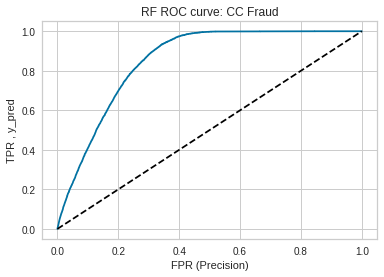

Area under curve (AUC):  0.8505831140421848


In [22]:
y_score2 = rf.predict_proba(X_valid)[:,1]
fpr, tpr, _ = roc_curve(y_valid, y_score2)

plt.title('RF ROC curve: CC Fraud')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR , y_pred')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))